In [1]:
import torch
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn, distributions, optim
from tqdm.autonotebook import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import gpzoo.pri_experiment_utilities as putil
from torch.distributions import MultivariateNormal

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def make_data(D=4, N=50):
  X = Normal(0, 1.0).sample((N,))*10
  Y = torch.zeros((D, N))
  for i in range(D):
    Y[i] = (i+1)*torch.sin(2**(i-1)*X) + Normal(0, 0.1).sample((N,))
  return X,Y

In [4]:
X, Y = make_data(D=3, N=1000)

In [5]:
print(X.shape)
print(Y.shape)

torch.Size([1000])
torch.Size([3, 1000])


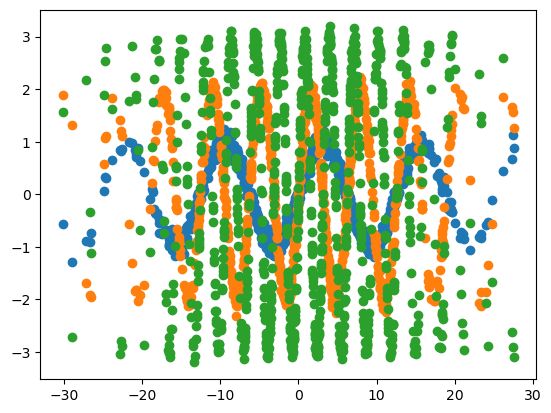

In [10]:
for i in range(3):
  plt.scatter(X, Y[i])
plt.savefig('synthetic_data.png')

In [7]:
def vnngp_kl(mz, Lz, Lu, mu, verbose=False):
    """
    """
    if verbose:
        print(f"mz shape: {mz.shape}")
        print(f"Lz shape: {Lz.shape}")
        print(f"Lu shape: {Lu.shape}")
        print(f"mu shape: {mu.shape}")

    # Number of inducing points
    M = mz.shape[0]

    # Compute the necessary parameters for all inducing points
    sj = torch.diag(Lz) ** 2  # Variance of the variational distribution
    bj = Lz  # Coefficients for the conditional distribution
    fj = torch.diag(bj)  # Conditional variance for the inducing points
    sn_j = sj  # Variance of the variational approximation for the inducing points

    # Compute the mean and variance terms for the KL divergence
    log_fj = torch.log(fj)
    log_sj = torch.log(sj)

    # Compute the KL divergence terms in a vectorized manner
    kl_terms = log_fj - log_sj - 1 + fj.reciprocal() * (sj + torch.sum(bj**2, dim=0) * sn_j + (mz - torch.matmul(bj.T, mu))**2)

    # Sum the KL divergence terms and scale by 0.5
    kl_divergence_sum = 0.5 * torch.sum(kl_terms) 

    return kl_divergence_sum

In [8]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []
    means = []
    scales = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)
        L = torch.tril(pU[0]) 
        covariance = L @ L.T
        #pU = MultivariateNormal(pU[1], covariance)
        #print("qU shape:", qU.event_shape, "pU shape:", pU.event_shape)
        #pU = distributions.MultivariateNormal(torch.zeros_like(pU[1]), scale_tril=L)
        logpY = pY.log_prob(y)
        #print(qU)
        #print(pU)

        ELBO = (logpY).mean(axis=0).sum()
        #print("qU shape: ", qU.shape)
        #print("pU shape: ", pU.shape)
        ELBO -= torch.sum(torch.vmap(vnngp_kl)(qU.mean, qU.scale_tril, model.gp.Lu, model.gp.mu))
        #ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [9]:
exp_data = {
    'model' :  ['vnngp'],
    'N' : [1000],
    'Z' : [50],
    'L' : [3],
}

In [10]:
kwargs = {
    'K' : 3,
    'lkzz_build' : 1,
    'model': 'VNNGP'
}

In [11]:
L = 3
M = 300
X = X[:, None]
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

/tmp/ipykernel_2033355/5430754.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


In [12]:
model = GaussianLikelihood(gp=gp, noise=0.1)
model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [13]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

In [14]:
X.shape

torch.Size([1000, 1])

In [15]:
model.to(device)
X_torch = torch.tensor(X).type(torch.float).to(device)
Y_torch = torch.tensor(Y).type(torch.float).to(device)
losses, means, scales = train(model, optimizer, X_torch, Y_torch, device, steps=2000, E=10, kwargs=kwargs)

/tmp/ipykernel_2033355/240529924.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_torch = torch.tensor(X).type(torch.float).to(device)
/tmp/ipykernel_2033355/240529924.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_torch = torch.tensor(Y).type(torch.float).to(device)


  0%|          | 0/2000 [00:00<?, ?it/s]

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()


In [49]:
torch.manual_seed(256)
exp_data = {
    'L' : [],
    'Z' : [],
    'N' : [],
    'model': [],
    'time': [],
}

new_data = {
    '1': [],
    '2': [],
    '3': [],
    '4': [],
    '5': [],
    '6': [],
    '7': [],
    '8': [],
    '9': [],
    '10': [],
}
points = [50, 500, 1000, 2000]
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#lengthscales = [2.0]
for k in K:
    times = []
    for m in points:
        # initialize dictionary
        L = 3
        N = 5000
        M = m
        kwargs = {
        'K' : 2, 
        'lkzz_build' : 1,
        'lengthscale' : l,
        'sigma': 1.0,
        }
        X, Y = make_data(D=3, N=N)
        X = X[:, None]
        dx = torch.multinomial(torch.ones(X.shape[0]), num_samples=N, replacement=False)
        kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
        gp = VNNGP(kernel, M=M, jitter=1e-1, K=2)
        gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
        gp.mu = nn.Parameter(torch.randn((L, M)))
        #gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST
    
        # update data dictionary
        exp_data['L'].append(L)
        exp_data['Z'].append(M)
        exp_data['N'].append(M)
        alg = 'VNNGP'
        exp_data['model'].append(alg)
    
        model = GaussianLikelihood(gp=gp, noise=0.05)
        model.to(device)
        X_train = X.to(device)
        Y_train = Y.to(device)
    
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)
    
        model.to(device)
        start_time = time.time()
        losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=1000, E=10, kwargs=kwargs)
        end_time = time.time()
        final_time = end_time - start_time
        exp_data['time'].append(final_time)
        times.append(final_time)
    new_data[str(k)] = times
    print(times)

    # save losses
    #fig1, ax1 = plt.subplots()
    #plt.plot(losses)
    #fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
    #plt.close(fig1)

    # save test figure
    #model.cpu()
    #X_test= torch.linspace(-30, 30, M)[:, None]
    #qF, qU, pU = model.gp(X_test, kwargs=kwargs)

    #fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
    #for j in range(3):
      #ax = ax2[j]  # Use the ith subplot's axes for plotting
      #mean = qF.mean.detach().cpu().numpy()[j]
      #sd = qF.scale.detach().cpu().numpy()[j]
      #ax.plot(X_test, mean)
      #ax.scatter(X, Y[j], alpha=0.5)
      #ax.fill_between(
          #  X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
          #  (mean - 2.0 * sd),
          #  (mean + 2.0 * sd),
          #  color="C0",
          #  alpha=0.3,
        #)
      #ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))
    #fig2.savefig(f'{alg}_N={num_N[i]}_Z={M}_test.png')

    # save model
   #torch.save(model.state_dict(), f'{alg}_N={num_N[i]}_Z={M}.pth')


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.745107889175415, 14.319554328918457, 21.735586166381836, 40.0973219871521]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.424198150634766, 14.265725374221802, 21.807537078857422, 39.97627830505371]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.27839183807373, 14.049269676208496, 21.55585527420044, 39.884851694107056]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.19450569152832, 13.9402015209198, 21.472225189208984, 39.90519952774048]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.16516923904419, 14.05036187171936, 21.5876305103302, 39.86968803405762]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.118388175964355, 13.941395282745361, 21.603529930114746, 39.8590943813324]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.205765008926392, 13.96729040145874, 21.65909743309021, 39.857932806015015]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.141805648803711, 14.041393756866455, 21.52894425392151, 39.85148763656616]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.183969736099243, 13.836090087890625, 21.601834535598755, 39.892220973968506]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[8.23267149925232, 14.005673170089722, 21.50820827484131, 39.895970821380615]


In [50]:
exp_data

{'L': [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'Z': [50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000],
 'N': [50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000,
  50,
  500,
  1000,
  2000],
 'model': ['VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNN

In [51]:
new_data

{'1': [8.745107889175415,
  14.319554328918457,
  21.735586166381836,
  40.0973219871521],
 '2': [8.424198150634766,
  14.265725374221802,
  21.807537078857422,
  39.97627830505371],
 '3': [8.27839183807373,
  14.049269676208496,
  21.55585527420044,
  39.884851694107056],
 '4': [8.19450569152832,
  13.9402015209198,
  21.472225189208984,
  39.90519952774048],
 '5': [8.16516923904419,
  14.05036187171936,
  21.5876305103302,
  39.86968803405762],
 '6': [8.118388175964355,
  13.941395282745361,
  21.603529930114746,
  39.8590943813324],
 '7': [8.205765008926392,
  13.96729040145874,
  21.65909743309021,
  39.857932806015015],
 '8': [8.141805648803711,
  14.041393756866455,
  21.52894425392151,
  39.85148763656616],
 '9': [8.183969736099243,
  13.836090087890625,
  21.601834535598755,
  39.892220973968506],
 '10': [8.23267149925232,
  14.005673170089722,
  21.50820827484131,
  39.895970821380615]}

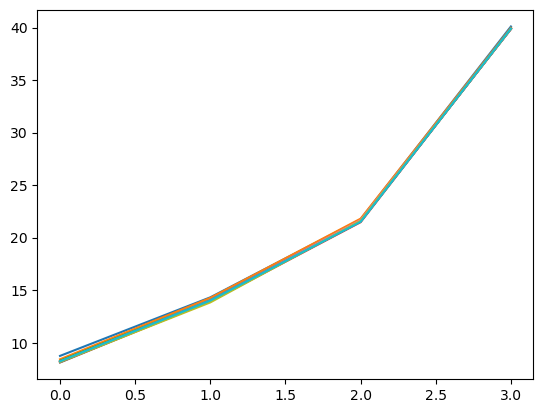

In [56]:
plt.plot(new_data['1'])
plt.plot(new_data['2'])
plt.plot(new_data['3'])
plt.plot(new_data['4'])
plt.plot(new_data['5'])
plt.plot(new_data['6'])
plt.plot(new_data['7'])
plt.plot(new_data['8'])
plt.plot(new_data['9'])
plt.plot(new_data['10'])

In [11]:
X_test = torch.linspace(-30, 30, 5000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    #ax2.clear()  # Clear the axes to redraw
    for j in range(3):
        ax = ax2[j]  # Use the ith subplot's axes for plotting
        mean = curr_mean[j]
        sd = curr_scale[j]
        ax.plot(X_test.cpu().numpy(), mean)  # Use X_test for plotting predictions
        #ax.scatter(X_train.cpu().numpy(), Y_train.cpu().numpy()[j], alpha=0.5)  # Adjust based on your Y_train shape
        ax.fill_between(
              X_test.cpu().numpy()[:, 0],  # Make sure X_test is 1D here
              (mean - 2.0 * sd),
              (mean + 2.0 * sd),
              color="C0",
              alpha=0.3,
          )
        ax.set_ylim([Y_train.min(), Y_train.max()])  # Optionally, set consistent y-limits
        ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [12]:
# Modify the update function to clear axes
def update(iteration):
    curr_mean = means[iteration]
    curr_scale = scales[iteration]
    for ax in ax2:
        ax.clear()  # Clear each subplot
    plot(curr_mean, curr_scale, ax2=ax2)

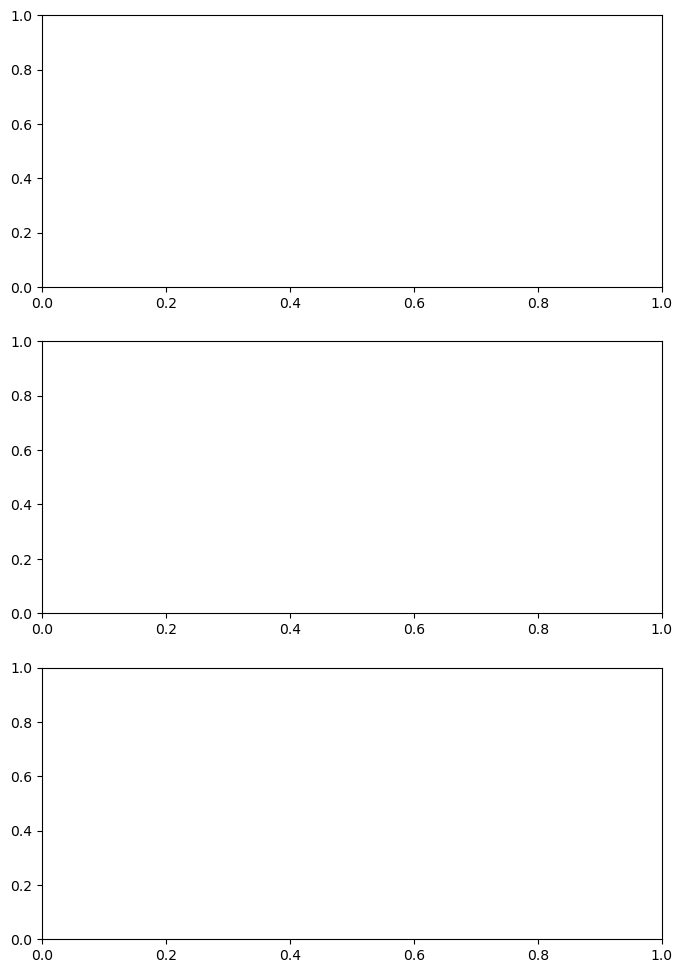

KeyboardInterrupt: 

In [13]:
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))
anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
#anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

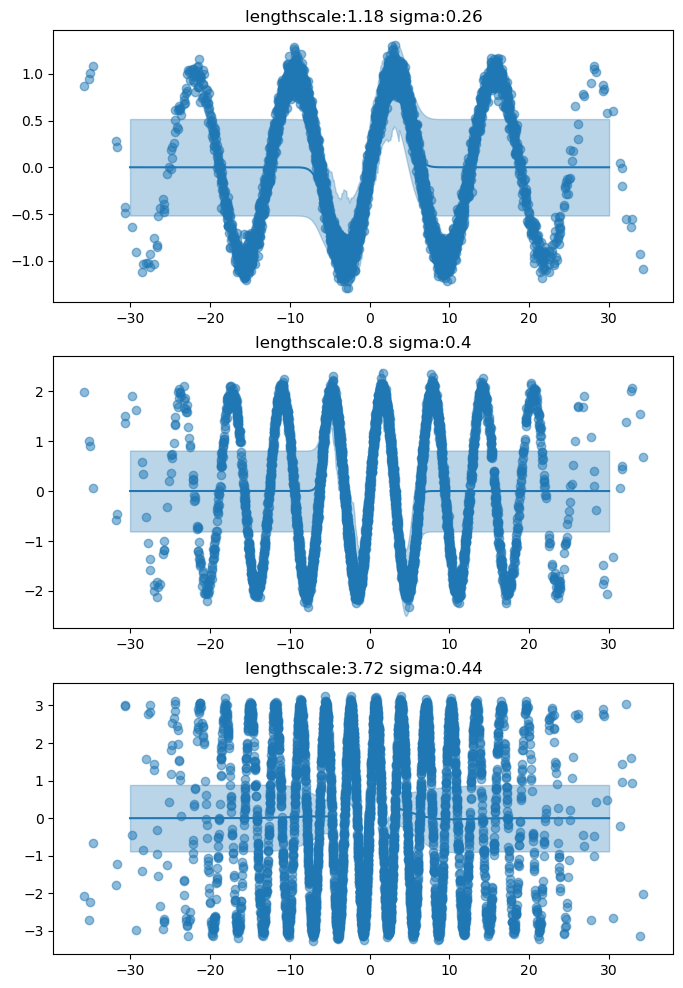

In [50]:
# save test figure
model.cpu()
X_test= torch.linspace(-30, 30, 1000)[:, None]
qF, qU, pU = model.gp(X_test)

fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
for j in range(3):
  ax = ax2[j]  # Use the ith subplot's axes for plotting
  mean = qF.mean.detach().cpu().numpy()[j]
  sd = qF.scale.detach().cpu().numpy()[j]
  ax.plot(X_test, mean)
  ax.scatter(X, Y[j], alpha=0.5)
  ax.fill_between(
  X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
      (mean - 2.0 * sd),
      (mean + 2.0 * sd),
      color="C0",
      alpha=0.3,)
  ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [21]:
means[0][0]

array([0.77064157, 0.5486614 , 1.1085385 , ..., 0.94941884, 0.34475577,
       0.5171135 ], dtype=float32)

In [ ]:
# save losses
fig1, ax1 = plt.subplots()
plt.plot(losses)
#fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
#plt.close(fig1)


In [ ]:
print(scales[0].shape)

In [ ]:
#X_test = torch.linspace(-30, 30, 1000)[:, None]
X_test = torch.linspace(-30, 30, 2000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    for j in range(3):
      ax = ax2[j]  # Use the ith subplot's axes for plotting
      mean = curr_mean[j]
      sd = curr_scale[j]
      ax.plot(X_train, mean)
      ax.scatter(X_train, Y_train[j], alpha=0.5)
      ax.fill_between(
            X_train[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
      ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))


In [ ]:
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))

# Animation Test
def update(iteration):
  curr_mean = means[iteration]
  curr_scale = scales[iteration]
  plot(curr_mean, curr_scale, ax2=ax2)

anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

In [ ]:
X_test = torch.linspace(-30, 30, 2000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    ax2.clear()  # Clear the axes to redraw
    for j in range(3):
        ax = ax2[j]  # Use the ith subplot's axes for plotting
        mean = curr_mean[j]
        sd = curr_scale[j]
        ax.plot(X_test.cpu().numpy(), mean)  # Use X_test for plotting predictions
        ax.scatter(X_train.cpu().numpy(), Y_train.cpu().numpy()[j], alpha=0.5)  # Adjust based on your Y_train shape
        ax.fill_between(
              X_test.cpu().numpy()[:, 0],  # Make sure X_test is 1D here
              (mean - 2.0 * sd),
              (mean + 2.0 * sd),
              color="C0",
              alpha=0.3,
          )
        ax.set_ylim([Y_train.min(), Y_train.max()])  # Optionally, set consistent y-limits
        ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [ ]:
# Modify the update function to clear axes
def update(iteration):
    curr_mean = means[iteration]
    curr_scale = scales[iteration]
    for ax in ax2:
        ax.clear()  # Clear each subplot
    plot(curr_mean, curr_scale, ax2=ax2)

In [ ]:
anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

# SVGP

In [ ]:
for i in range(1):
    X, Y = make_data(D=3, N=1000)
    X = X[:, None]

    # initialize dictionary
    L = 3
    M = 100

    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
    gp = SVGP(kernel, jitter=1e-1)
    gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
    gp.mu = nn.Parameter(torch.randn((L, M)))
    gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

    # update data dictionary
    exp_data['L'].append(L)
    exp_data['Z'].append(M)
    exp_data['N'].append(num_N[i])
    alg = 'SVGP'
    exp_data['model'].append(alg)

    model = GaussianLikelihood(gp=gp, noise=0.1)
    model.to(device)
    X_train = X.to(device)
    Y_train = Y.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

    model.to(device)
    start_time = time.time()
    losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=2000, E=10)
    end_time = time.time()
    final_time = end_time - start_time
    exp_data['time'].append(final_time)
    '''
    # save losses
    fig1, ax1 = plt.subplots()
    plt.plot(losses)
    #fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
    plt.close(fig1)

    # save test figure
    model.cpu()
    X_test= torch.linspace(-30, 30, 1000)[:, None]
    qF, qU, pU = model.gp(X_test)

    fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
    for j in range(3):
      ax = ax2[j]  # Use the ith subplot's axes for plotting
      mean = qF.mean.detach().cpu().numpy()[j]
      sd = qF.scale.detach().cpu().numpy()[j]
      print(mean.shape)
      print(sd.shape)
      ax.plot(X_test, mean)
      ax.scatter(X, Y[j], alpha=0.5)
      ax.fill_between(
            X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
      ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))
    #fig2.savefig(f'{alg}_N={num_N[i]}_Z={M}_test.png')

    # save model
    #torch.save(model.state_dict(), f'{alg}_N={num_N[i]}_Z={M}.pth')
    '''


In [39]:
exp_data

{'L': [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'Z': [50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000],
 'N': [50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  50,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  500,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000],
 'model': ['VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNNGP',
  'VNN

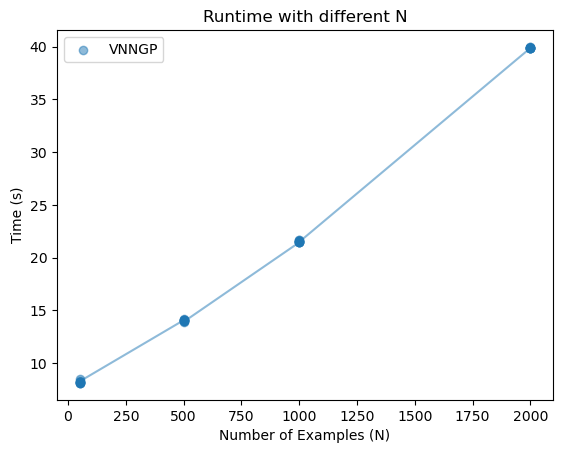

In [36]:
plt.scatter(exp_data['N'], exp_data['time'], label="VNNGP", alpha=0.5)
plt.plot(exp_data['N'], exp_data['time'], alpha=0.5)
#plt.scatter(exp_data['N'][5:], exp_data['time'][5:], label="SVGP")
#plt.plot(exp_data['N'][5:], exp_data['time'][5:])
plt.title("Runtime with different N")
plt.xlabel("Number of Examples (N)")
plt.ylabel("Time (s)")
plt.legend()
plt.savefig("Runtime_changing_N")

In [ ]:
np.save('z_benchmarking.npy', exp_data)

In [ ]:
X_test = torch.linspace(-30, 30, 1000)[:, None]
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))

# Animation Test
def update(iteration):
  curr_mean = means[iteration]
  curr_scale = scales[iteration]
  plot(curr_mean, curr_scale, ax2=ax2)

anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("SVGP_anim_test.gif", writer='pillow', fps=10, dpi=50)